In [1]:
import scipy.spatial
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import ProjectiveTransform
from skimage.transform import warp
import skimage
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)

In [3]:
def RANSAC(matches,iteration = 250, threshold = 5):
    '''
    matches: (n,4)--(x_left,y_left,x_right,y_right)
    '''
    num_of_sample = 4
    n = 1
    num_of_matches = np.shape(matches)[0]
    
    while(n<iteration):
        if num_of_sample == 4:
            inliers = np.random.choice(np.arange(num_of_matches), size=num_of_sample)
        A = np.zeros((2*num_of_sample,9))
        for i in range(num_of_sample):
            current_match = matches[inliers[i],:]
            x_left,y_left,x_right,y_right = current_match
            A[2*i,:] = np.array([0,0,0,x_left,y_left,1,-y_right*x_left,-y_right*y_left,-y_right])
            A[2*i+1,:] = np.array([x_left,y_left,1,0,0,0,-x_right*x_left,-x_right*y_left,-x_right])
        U, s, V = np.linalg.svd(A)
        trans_mat = np.reshape(V[len(V)-1],(3,3))
        inliers = []
        num_of_inliers = 0
        residual = []
        for i in range(num_of_matches):
            X = np.dot(trans_mat,np.array([matches[i][0],matches[i][1],1]))
            x = X[0]/X[2]
            y = X[1]/X[2]
            x1, y1 = matches[i][2],matches[i][3]
            if np.sqrt((x1-x)**2+(y1-y)**2)<threshold:
                inliers.append(i)
                residual.append(np.sqrt((x1-x)**2+(y1-y)**2))
                num_of_inliers += 1
        if num_of_inliers<15:
            num_of_sample = 4
        else:
            num_of_sample = num_of_inliers
            n = n+1
    mean_of_residual = np.mean(residual)
    return inliers, num_of_inliers, mean_of_residual, trans_mat

In [4]:
def normalize(image):
    return (image-np.min(image))/(np.max(image)-np.min(image))

In [5]:
img_left = cv2.imread('left.jpg')
img_right = cv2.imread('right.jpg')
gray_left = cv2.cvtColor(img_left,cv2.COLOR_BGR2GRAY)#.astype(np.float64)
gray_right = cv2.cvtColor(img_right,cv2.COLOR_BGR2GRAY)#.astype(np.float64)

sift = cv2.xfeatures2d.SIFT_create()
kp_left, des_left = sift.detectAndCompute(gray_left,None)
kp_right, des_right = sift.detectAndCompute(gray_right,None)
print(np.shape(des_left))
print(np.shape(des_right))

(4410, 128)
(3484, 128)


In [6]:
sift_distance = scipy.spatial.distance.cdist(des_left,des_right,'sqeuclidean')

In [7]:
init_pairs = np.argwhere(sift_distance<10000)
init_pairs = list(init_pairs)
print(np.shape(init_pairs))
matches = []
for i in range(np.shape(init_pairs)[0]):
    idx_left, idx_right = init_pairs[i]
    x_left, y_left = kp_left[idx_left].pt
    x_right, y_right = kp_right[idx_right].pt
    matches.append(np.array([x_right,y_right,x_left,y_left]))
matches = np.array(matches)

(61, 2)


In [8]:
print(np.shape(matches))

(61, 4)


In [29]:
inliers, num_of_inliers, mean_of_residual, trans_mat = RANSAC(matches,threshold=0.5
                                                                ,iteration=50)
print(num_of_inliers)
trans_object1 = ProjectiveTransform(trans_mat)
left_new = warp(gray_left,trans_object1)

18


In [30]:
print((num_of_inliers, mean_of_residual))

(18, 0.24030791597392043)


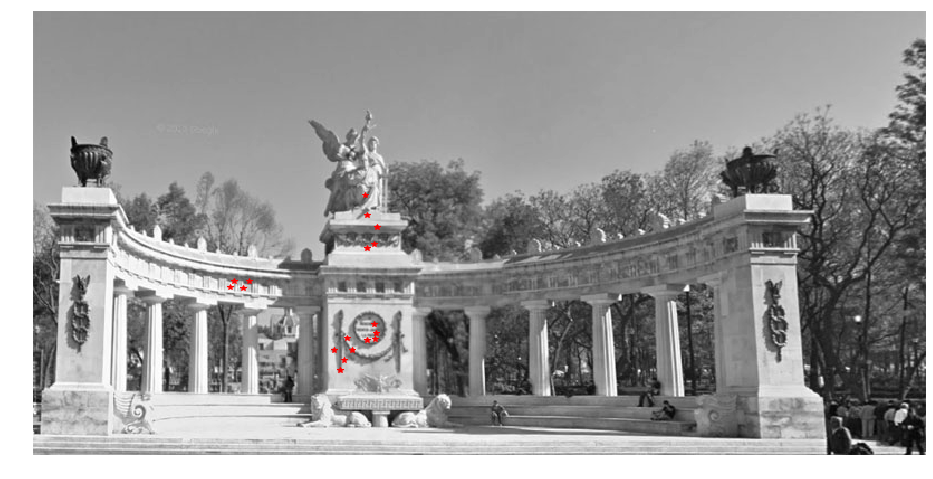

In [51]:
plt.imshow(gray_right,cmap='gray')
plt.plot([matches[p][0] for p in inliers],[matches[p][1] for p in inliers],'r*')
plt.axis('off')
plt.show()

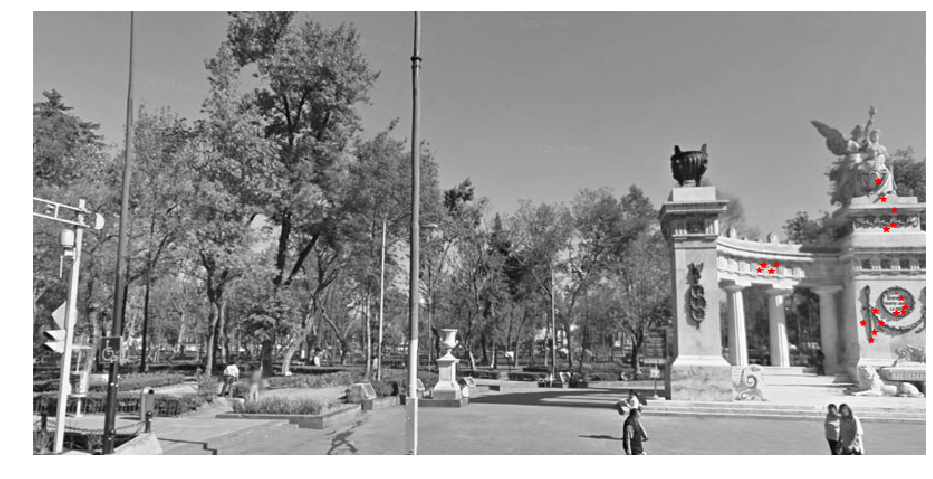

In [52]:
plt.imshow(gray_left,cmap='gray')
plt.plot([matches[p][2] for p in inliers],[matches[p][3] for p in inliers],'r*')
plt.axis('off')
plt.show()

In [53]:
x,y = np.shape(gray_left)
new = np.zeros((x,2*y))
new[:,:y] = gray_left
new[:,y:] = gray_right

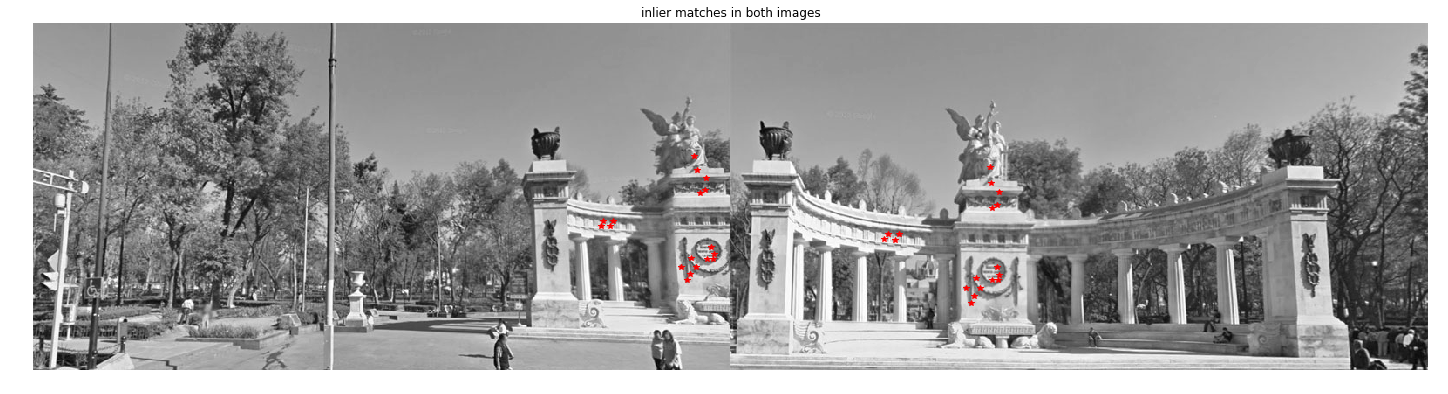

In [58]:
plt.rcParams['figure.figsize'] = (25, 20)
plt.imshow(new,cmap='gray')
plt.plot([matches[p][2] for p in inliers],[matches[p][3] for p in inliers],'r*')
plt.plot([matches[p][0]+y for p in inliers],[matches[p][1] for p in inliers],'r*')
plt.title('inlier matches in both images')
plt.axis('off')
plt.show()

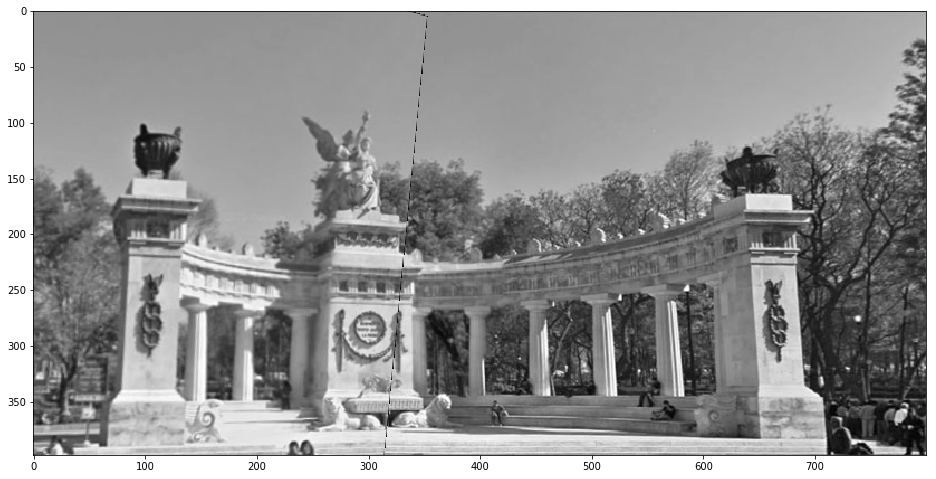

In [31]:

sel = left_new !=0
right_new =  normalize(gray_right)
right_new[sel] = 0
plt.imshow(left_new+right_new,cmap='gray')
plt.show()

In [32]:
trans_mat

array([[-7.32737361e-04, -3.96268431e-05, -9.93468572e-01],
       [ 3.45711583e-04, -1.41861998e-03, -1.14076994e-01],
       [ 1.20412951e-06,  1.58939876e-07, -1.99132907e-03]])

In [33]:
x,y = np.shape(gray_left)
idx_list = []
for i in range(x):
    for j in range(y):
        idx_list.append(np.array([i,j,1]))
idx_list = np.array(idx_list).T

In [34]:
np.shape(idx_list)

(3, 318400)

In [35]:
temp_idx = np.dot(trans_mat,idx_list)
np.shape(temp_idx)

(3, 318400)

In [36]:
temp_idx[0,:] = temp_idx[0,:]/temp_idx[2,:]
temp_idx[1,:] = temp_idx[1,:]/temp_idx[2,:]

In [37]:
max_x,min_x,max_y,min_y = np.max(temp_idx[0,:]),np.min(temp_idx[0,:]), np.max(temp_idx[1,:]),np.min(temp_idx[1,:])

In [38]:
print(max_x,min_x,max_y,min_y )

949.3113295592015 498.8972387716565 800.9157531265196 -15.311348146876682


In [39]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

In [40]:
result = warpTwoImages(gray_left,gray_right,trans_mat)

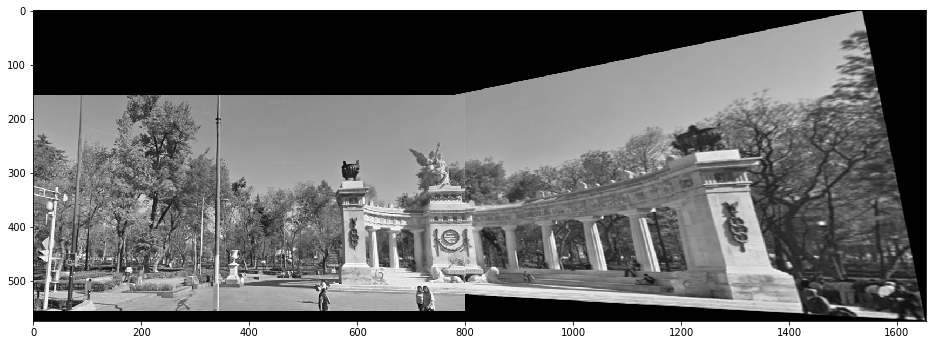

In [41]:
plt.imshow(result,cmap = 'gray')
plt.show()

In [43]:
x,y = np.shape(result)

In [44]:
result_color = np.zeros((x,y,3))

In [45]:
result_color[:,:,0] = warpTwoImages(img_left[:,:,2],img_right[:,:,2],trans_mat)
result_color[:,:,1] = warpTwoImages(img_left[:,:,1],img_right[:,:,1],trans_mat)
result_color[:,:,2] = warpTwoImages(img_left[:,:,0],img_right[:,:,0],trans_mat)

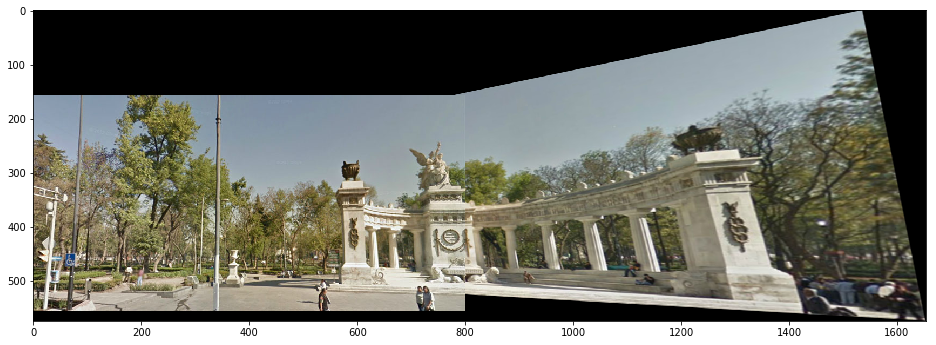

In [46]:
plt.imshow(normalize(result_color))
plt.show()